#Notebook for link prediciton analysis
##Coursework 2015, HSE - DataSci
###Sergey Korolev

####First attempt, similarity based algorithms

####Networks used:
1. UciNet data - http://vlado.fmf.uni-lj.si/pub/networks/data/UciNet/UciData.htm
2. Pajek datasets - http://vlado.fmf.uni-lj.si/pub/networks/data/default.htm
3. ND - http://www3.nd.edu/~networks/resources.htm (possibly already in pajek ds)
4. Alex Arenas - http://deim.urv.cat/~alexandre.arenas/data/welcome.htm
5. Stanford nets - http://snap.stanford.edu/data/
6. Newman - http://www-personal.umich.edu/~mejn/netdata/

Really hope to sift through them or just write some interface to load them into networkx to work with them.

#####All theoretical notes on the algroithms are quoted directly from Linyuan Lü, Tao Zhou, Link prediction in complex networks: A survey, Physica A 390, 2011

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import operator
import pandas as pd
import scipy.io as sci
%matplotlib inline

In [2]:
G = nx.karate_club_graph()

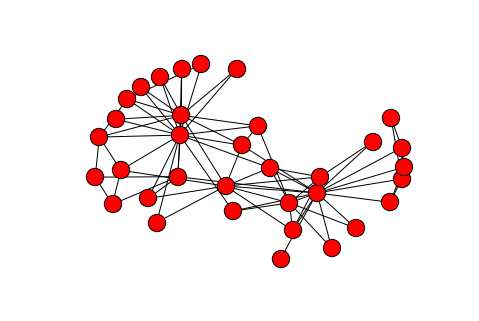

In [3]:
pos = nx.spring_layout(G)
nx.draw(G, pos)

In [2]:
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    size = len(ys) // n
    leftovers= ys[size*n:]
    for c in xrange(n):
        if leftovers:
           extra= [ leftovers.pop() ] 
        else:
           extra= []
        yield ys[c*size:(c+1)*size] + extra

####Common neighbours
For a node x, let $\Gamma(x)$ denote the set of neighbors of $x$. In common sense, two nodes, $x$ and $y$, are more likely to have a link if they have many common neighbors. The simplest measure of this neighborhood overlap is the directed count, namely
$$s_{xy}^{CN} = |\Gamma(x) \cap \Gamma(y)|,$$
where $|Q|$ is the cardinality of the set $Q$. It is obvious that $s_{xy} = (A^2)_{xy}$, where $A$ is the adjacency matrix: $A_{xy} = 1$ if $x$ and $y$ are directly connected and $A_{xy} = 0$ otherwise. Note that, $(A^2)_{xy}$ is also the number of different paths with length 2 connecting $x$ and $y$. Newman [40] used this quantity in the study of collaboration networks, showing a positive correlation between the number of common neighbors and the probability that two scientists will collaborate in the future. Kossinets and Watts [14] analyzed a large-scale social network, suggesting that two students having many mutual friends are very probable to be friends in future. The following six indices are also based on the number of common neighbors, yet with different normalization methods.

In [5]:
folds = [i for i in chunk(G.edges(), 10)]

In [6]:
subs = []
for i in xrange(10):
    graph = G.copy()
    for c in folds[i]:
        graph.remove_edge(*c)
    subs.append(graph.copy())

In [107]:
def common_neighbours(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = mat[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Salton Index
It is defined as
$$s_{xy}^{Salton} = \frac{|\Gamma(x) \cap \Gamma(y)|}{\sqrt{k_x \times k_x}}$$
where $k_x$ is the degree of node $x$. The Salton index is also called the cosine similarity in the literature.

In [108]:
def salton_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 and k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(np.sqrt(j * k))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Jaccard Index
This index was proposed by Jaccard over a hundred years ago, and is defined as
$$s_{xy}^{Jaccard} = \frac{|\Gamma(x) \cap \Gamma(y)|}{|\Gamma(x) \cup \Gamma(y)|}$$

In [109]:
def jaccard_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            if nx.degree(i, e[0]) != 0 or nx.degree(i, e[1]) != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(len(set(i[e[0]])|set(i[e[1]])))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Sorensen Index
This index is used mainly for ecological community data, and is defined as
$$s_{xy}^{Sorensen} = \frac{2|\Gamma(x) \cap \Gamma(y)|}{k_x + k_y}$$

In [110]:
def sorensen_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 or k != 0:
                edgesWithScore[e] = 2*float(mat[e[0]][e[1]])/float(j + k)
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Hub Promoted Index (HPI)
This index is proposed for quantifying the topological overlap of pairs of substrates in metabolic networks, and is defined as
$$s_{xy}^{HPI} = \frac{|\Gamma(x) \cap \Gamma(y)|}{min\{k_x, k_y\}}$$
Under this measurement, the links adjacent to hubs are likely to be assigned high scores since the denominator is determined by the lower degree only.

In [111]:
def hub_promoted_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 and k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(min(j, k))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Hub Depressed Index (HDI)
Analogously to the above index, we also consider a measurement with the opposite effect on hubs, defined as
$$s_{xy}^{HDI} = \frac{|\Gamma(x) \cap \Gamma(y)|}{max\{k_x, k_y\}}$$

In [112]:
def hub_depressed_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 or k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(max(j, k))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Leicht–Holme–Newman Index (LHN1)
This index assigns high similarity to node pairs that have many common neighbors compared not to the possible maximum, but to the expected number of such neighbors. It is defined as
$$s_{xy}^{LHN1} = \frac{|\Gamma(x) \cap \Gamma(y)|}{k_x \times k_y}$$
where the denominator, $k_x \times k_y$, is proportional to the expected number of common neighbors of nodes $x$ and $y$ in the configuration model. We use the abbreviation LHN1 to distinguish this index to another index (named as LHN2 index) also proposed by Leicht, Holme and Newman.

In [113]:
def LHN1_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 and k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(j * k)
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Preferential Attachment Index (PA)
The mechanism of preferential attachment can be used to generate evolving scale- free networks, where the probability that a new link is connected to the node $x$ is proportional to $k_x$. A similar mechanism can also lead to scale-free networks without growth, where at each time step, an old link is removed and a new link is generated. The probability that this new link will connect $x$ and $y$ is proportional to $k_x \times k_y$. Motivated by this mechanism, the corresponding similarity index can be defined as
$$s_{xy}^{PA} = k_x \times k_y$$
which has been widely used to quantify the functional significance of links subject to various network-based dynamics, such as percolation, synchronization and transportation. Note that, this index does not require the information of the neighborhood of each node, as a consequence, it has the least computational complexity.

In [114]:
def preferential_attachment_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = nx.degree(i, e[0]) * nx.degree(i, e[1])
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Adamic–Adar Index (AA)
This index refines the simple counting of common neighbors by assigning the less- connected neighbors more weights, and is defined as
$$s_{xy}^{AA} = \sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{log k_z}$$

In [115]:
def adamic_adar_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = np.sum(1/np.log(nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()))
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1
        
    return np.mean(auc)

####Resource Allocation Index (RA)
This index is motivated by the resource allocation dynamics on complex networks. Consider a pair of nodes, $x$ and $y$, which are not directly connected. The node $x$ can send some resource to $y$, with their common neighbors playing the role of transmitters. In the simplest case, we assume that each transmitter has a unit of resource, and will equally distribute it to all its neighbors. The similarity between $x$ and $y$ can be defined as the amount of resource $y$ received from $x$, which is
$$s_{xy}^{RA} = \sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{k_z}$$
Clearly,this measure is symmetric,namely $s_{xy} = s_{yx}$.Note that, although resulting from different motivations, the AA index and RA index have very similar form. Indeed, they both depress the contribution of the high-degree common neighbors. AA index takes the form $(log k )^{−1}$ while RA index takes the form $k^{−1}$. The difference is insignificant when the degree, $k_z$, is small, while it is considerable when $k_z$ is large. In other words, RA index punishes the high-degree common neighbors more heavily than AA.

In [116]:
def resourse_allocation_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = np.sum(1/np.array(
                    nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()).astype(float))
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1
        
    return np.mean(auc)

In [117]:
def run_local_similarity_indices(G, symmetric = True, nfolds = 10, seed = 0):
    random.seed(seed)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    cn = common_neighbours(folds, subs, symmetric = symmetric)
    print 'cn'
    sai = salton_index(folds, subs, symmetric = symmetric)
    print 'sai'
    ji = jaccard_index(folds, subs, symmetric = symmetric)
    print 'ji'
    soi = sorensen_index(folds, subs, symmetric = symmetric)
    print 'soi'
    hpi = hub_promoted_index(folds, subs, symmetric = symmetric)
    print 'hpi'
    hdi = hub_depressed_index(folds, subs, symmetric = symmetric)
    print 'hdi'
    lhn1 = LHN1_index(folds, subs, symmetric = symmetric)
    print 'LHN1'
    pai = preferential_attachment_index(folds, subs, symmetric = symmetric)
    print 'pai'
    aai = adamic_adar_index(folds, subs, symmetric = symmetric)
    print 'aai'
    rai = resourse_allocation_index(folds, subs, symmetric = symmetric)
    print 'rai'
    aucs = {'CN' : cn, 
            'SaI' : sai, 
            'JI' : ji, 
            'SoI' : soi,
            'HPI' : hpi,
            'HDI' : hdi,
            'LHN1' : lhn1,
            'PAI' : pai,
            'AAI' : aai,
            'RAI' : rai}
    return aucs

In [18]:
df = pd.DataFrame(columns = ['CN', 'SaI', 'JI', 'SoI', 'HPI', 'HDI', 'LHN1', 'PAI', 'AAI', 'RAI'])

In [19]:
df.loc['karate club'] = run_local_similarity_indices(nx.karate_club_graph())

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [20]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396


In [21]:
pajek_football = nx.read_pajek('./netws/pajekds/football.net')

In [22]:
fixed_pajek_football = nx.Graph(nx.convert_node_labels_to_integers(pajek_football, first_label = 0))

In [23]:
df.loc['pajek football'] = run_local_similarity_indices(fixed_pajek_football)

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [24]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek football,0.662064,0.588845,0.587198,0.587198,0.600118,0.578401,0.490883,0.754943,0.658615,0.652655


In [25]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
pajek_us_air = 0
df.loc['pajek_us_air'] = run_local_similarity_indices(fixed_pajek_us_air)

In [28]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek football,0.662064,0.588845,0.587198,0.587198,0.600118,0.578401,0.490883,0.754943,0.658615,0.652655
pajek_us_air,0.934896,0.908560,0.898030,0.898030,0.870076,0.891644,0.767659,0.886947,0.945853,0.951752


In [31]:
pajek_netscience = nx.read_pajek('./netws/pajekds/netsience.net')

In [32]:
fixed_pajek_netscience = nx.Graph(nx.convert_node_labels_to_integers(pajek_netscience, first_label = 0))
pajek_netscience = 0
df.loc['pajek netscience'] = run_local_similarity_indices(fixed_pajek_netscience)
fixed_pajek_netscience = 0

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [34]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek football,0.662064,0.588845,0.587198,0.587198,0.600118,0.578401,0.490883,0.754943,0.658615,0.652655
pajek_us_air,0.934896,0.908560,0.898030,0.898030,0.870076,0.891644,0.767659,0.886947,0.945853,0.951752
pajek netscience,0.940165,0.940314,0.940269,0.940269,0.940200,0.940221,0.939941,0.679141,0.940459,0.940473


In [35]:
df.to_csv('first_four.csv')

###Global similarity indices

####1. Katz Index
This index is based on the ensemble of all paths, which directly sums over the collection of paths
and is exponentially damped by length to give the shorter paths more weights. The mathematical expression reads
$$S^{Katz} = (I - \beta A)^{-1} - I.$$
Note that, β must be lower than the reciprocal of the largest eigenvalue of matrix A to ensure the convergence of Eq.

In [3]:
def katz_index(folds, subs, beta = 0, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        ide = np.identity(len(mat))
        if beta == 0:
            beta = (1/float(max(np.linalg.eig(mat)[0])))/2
            print 'beta =', beta
        sim = np.linalg.inv(ide - beta*mat) - ide
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####2. Leicht–Holme–Newman Index (LHN2)
This index is a variant of the Katz index. Based on the concept that two
nodes are similar if their immediate neighbors are themselves similar, one obtains a self-consistent matrix formulation
$$S^{LHN2} = 2 m \lambda_1 D^{-1} (I - \frac{\phi A}{\lambda_1})^{-1} D^{-1},$$
where $\lambda_1$ is the largest eigenvalue of $A$, $m$ is the total number of edges in the network and $D$ is the degree matrix with $D_{xy} = \delta_{xy}k_x$ and $\phi (0 < \phi < 1)$ is a free parameter. The choosing of $\phi$ depends on the investigated network, and smaller $\phi$ assigns more weights on shorter paths.

In [4]:
def lhn2_index(folds, subs, phi = 0.5, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        ide = np.identity(len(mat))
        dma = np.diagflat(mat.sum(axis = 1))
        if np.linalg.det(dma) != 0:
            lambd = float(max(np.linalg.eig(mat)[0]))
            sim = (2 * i.number_of_edges() * lambd * np.linalg.inv(dma)).dot(np.linalg.inv(
            ide - (phi/lambd) * mat)).dot(np.linalg.inv(dma))
            edgesWithScore = {}
            edges = nx.non_edges(i)
            for e in edges:
                edgesWithScore[e] = sim[e[0]][e[1]]
            highScore = 0
            sameScore = 0
            allScore = 0
            for e in edgesWithScore:
                if e not in folds[step]:
                    for s in folds[step]:
                        if edgesWithScore[e] < edgesWithScore[s]:
                            highScore += 1
                        elif edgesWithScore[e] == edgesWithScore[s]:
                            sameScore += 1
                        allScore += 1
            auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####3. Average Commute Time (ACT)
Assuming two nodes are more similar if they have a smaller average commute time, then the similarity between the nodes x and y can be defined as the reciprocal of $n(x, y)$, namely (the constant factor M is removed)
$$S_{xy}^{ACT} = \frac{1}{l_{xx}^{+} + l_{yy}^{+} - 2l_{xy}^{+}},$$
where $l_{xy}^{+}$ denotes the corresponding entry in the Laplacian matrix, $L^{+} (L = D − A)$.

In [5]:
def act_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = 1/float(sim[e[0]][e[0]] + sim[e[1]][e[1]] - 2*sim[e[0]][e[1]])
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####4. Cosine based on $L^{+}$
This index is an inner-product-based measure. In the Euclidean space spanned by $v_x = \Lambda^{\frac{1}{2}} U^{T} e_x,$ where $U$ is an orthonormal matrix made of the eigenvectors of $L^{+}$ ordered in decreasing order of corresponding eigenvalue $\lambda_x, \Lambda = diag(\lambda_x), e_x$ is an $N \times 1$ vector with the $x$th element equal to $1$ and others all equal to $0$, and $T$ is the matrix transposition, the pseudoinverse of the Laplacian matrix are the inner products of the node vectors, $l_{xy}^{+} = v_x^T v_y$. Accordingly, the cosine similarity is defined as the cosine of the node vectors, namely
$$s_{xy}^{cos^{+}} = cos(x, y)^{+} = \frac{v_x^T v_y}{|v_x| \cdot |v_y|} = \frac{l_{xy}^{+}}{\sqrt{l_{xx}^{+} \cdot l_{yy}^{+}}}.$$

In [6]:
def cbl_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = float(sim[e[0]][e[1]])/np.sqrt(sim[e[0]][e[0]] * sim[e[1]][e[1]])
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####5. Random Walk with Restart (RWR)
This index is a direct application of the PageRank algorithm. Consider a random walker starting from node $x$, who will iteratively move to a random neighbor with probability $c$ and return to node $x$ with probability $1 − c$. Denote by $q_{xy}$ the probability this random walker locates at node $y$ in the steady state, we have
$$q_{x} = c P^T q_x + (1 - c) e_x,$$
where $P$ is the transition matrix with $P_{xy} = 1/k_x$ if $x$ and $y$ are connected, and $P_{xy} = 0$ otherwise. The solution is straightforward, as
$$q_x = (1 - c) (I - cP^T)^{-1} e_x.$$
The RWR index is thus defined as
$$s_{xy}^{RWR} = q_{xy} + q_{yx},$$
where $q_{xy}$ is the $y$th element of the vector $q_x$.

In [7]:
def rwr_index(folds, subs, c = 0.5, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        ide = np.identity(len(mat))
        pmt = np.identity(len(mat))
        es = []
        for a in i.nodes():
            e = np.zeros(len(mat))
            e[a] = 1
            es.append(e)
            for b in i.nodes():
                try:
                    nx.shortest_path_length(i, source = a, target = b)
                except:
                    pmt[a][b] = 0
                else:
                    if nx.degree(i, a) != 0:
                        pmt[a][b] = 1/float(nx.degree(i, a))
                    else:
                        pmt[a][b] = 0
        es = np.array(es)
        qs = []
        for a in i.nodes():
            if np.linalg.det(ide - c*np.transpose(pmt)) != 0:
                q = ((1 - c)*np.linalg.inv(ide - c*np.transpose(pmt))).dot(es[a])
            else:
                q = es[a]
            qs.append(q)
        qs = np.array(qs)
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = qs[e[0]][e[1]] + qs[e[1]][e[0]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####6. SimRank
Similar to the LHN2, SimRank is defined in a self-consistent way, according to the assumption that
two nodes are similar if they are connected to similar nodes.
$$s_{xy}^{SimRank} = C \cdot \frac{\sum_{z \in \Gamma(x)} \sum_{z' \in \Gamma(y)} s_{zz'}^{SimRank}}{k_x \cdot k_y},$$
where $s_{xx} = 1$ and $C \in [0, 1]$ is the decay factor. The SimRank can also be interpreted by the random walk process, that is, $s_{xy}^{SimRank}$ measures how soon two random walkers, respectively starting from nodes $x$ and $y$, are expected to meet at a certain node. 

####7. Matrix Forest Index (MFI)
This index is defined as
$$S = (I + L)^{-1},$$
where the similarity between $x$ and $y$ can be understood as the ratio of the number of spanning rooted forests such that nodes $x$ and $y$ belong to the same tree rooted at $x$ to all spanning rooted forests of the network. A parameter-dependent variant of MFI is
$$S = (I + \alpha L)^{-1}, \ \ \ \alpha > 0.$$

In [8]:
def matrix_forest_index(folds, subs, alpha = 1, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        ide = np.identity(len(mat))
        sim = np.linalg.inv(ide + alpha*(dma - mat))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [10]:
def run_global_similarity_indices(G, symmetric = True, nfolds = 10, seed = 0):
    random.seed(seed)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    ki = katz_index(folds, subs, symmetric = symmetric)
    print 'ki'
    lhn2 = lhn2_index(folds, subs, symmetric = symmetric)
    print 'lhn2'
    act = act_index(folds, subs, symmetric = symmetric)
    print 'act'
    cbl = cbl_index(folds, subs, symmetric = symmetric)
    print 'cbl'
    rwr = rwr_index(folds, subs, symmetric = symmetric)
    print 'rwr'
    mfi = matrix_forest_index(folds, subs, symmetric = symmetric)
    print 'mfi'
    aucs = {'KI' : ki, 
            'LHN2' : lhn2, 
            'ACT' : act, 
            'CBL' : cbl,
            'RWR' : rwr,
            'MFI' : mfi}
    return aucs

In [14]:
df2 = pd.DataFrame(columns = ['KI', 'LHN2', 'ACT', 'CBL', 'RWR', 'MFI'])

In [15]:
df2.loc['karate club'] = run_global_similarity_indices(nx.karate_club_graph())

ki
lhn2
act
cbl
rwr
mfi


C:\Anaconda2\lib\site-packages\IPython\kernel\__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Anaconda2\lib\site-packages\IPython\kernel\__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


In [16]:
pajek_football = nx.read_pajek('./netws/pajekds/football.net')
fixed_pajek_football = nx.Graph(nx.convert_node_labels_to_integers(pajek_football, first_label = 0))
df2.loc['pajek football'] = run_global_similarity_indices(fixed_pajek_football)

ki
lhn2
act
cbl
rwr
mfi


In [19]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
df2.loc['pajek_us_air'] = run_global_similarity_indices(fixed_pajek_us_air)

ki
lhn2
act
cbl
rwr
mfi


C:\Anaconda2\lib\site-packages\IPython\kernel\__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


In [20]:
df2

,KI,LHN2,ACT,CBL,RWR,MFI
karate club,0.755219,0.610452,0.666190,0.735803,0.619955,0.748715
pajek football,0.724598,0.521484,0.747681,0.596968,0.746666,0.679982
pajek_us_air,0.919737,NaN,0.891851,0.904232,0.832092,0.912749


In [21]:
df2.to_csv('first_three_global.csv')

###Quasi-local indices

####1.Local Path Index (LP)
To provide a good tradeoff of accuracy and computational complexity, we here introduce an index that takes consideration of local paths, with wider horizon than CN. It is defined as
$$S^{LP} = A^2 + \epsilon A^3,$$
where $\epsilon$ is a free parameter. Clearly, this measure degenerates to CN when $\epsilon = 0$. And if $x$ and $y$ are not directly connected (this is the case we are interested in), $(A^3)_{xy}$ is equal to the number of different paths with length 3 connecting $x$ and $y$. This index can be extended to account for higher-order paths, as
$$S^{LP(n)} = A^2 + \epsilon A^3 + \epsilon^2 A^4 + \cdots + \epsilon^{n-2} A^n,$$
where $n > 2$ is the maximal order. With the increasing of $n$, this index asks for more information and computation. Especially, when $n \rightarrow \infty$, $S^{LP(n)}$ will be equivalent to the Katz index that takes into account all paths in the network. The computational complexity of this index in an uncorrelated network is $\mathbb{O}(N⟨k⟩^n)$, which grows fast with the increasing of n and will exceed the complexity for calculating the Katz index (approximate to $\mathbb{O}(N^3)$) for large $n$. Experimental results show that the optimal $n$ is positively correlated with the average shortest distance of the network.

In [9]:
def local_path_index(folds, subs, epsilon = 0.01, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        sim = mat.dot(mat) + epsilon*mat.dot(mat.dot(mat))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [10]:
local_path_index(folds, subs)

NameError: name 'folds' is not defined

####2. Local Random Walk (LRW)
To measure the similarity between nodes $x$ and $y$, a random walker is initially put on node $x$ and thus the initial density vector $\pi_x(0) = e_x$. This density vector evolves as $\pi_x(t + 1) = P^T \pi_x(t)$ for $t \geq 0$. The LRW index at time step $t$ is thus defined as
$$s_{xy}^{LRW} (t) = q_x \pi_{xy}(t) + q_y \pi_{yx} (t).$$
where $q$ is the initial configuration function. 

In [11]:
def lrw_index(folds, subs, c = 0.5, nsteps = 3, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        pim = np.identity(len(mat))
        pmt = np.identity(len(mat))
        es = []
        for a in i.nodes():
            e = np.zeros(len(mat))
            e[a] = 1
            es.append(e)
            for b in i.nodes():
                try:
                    nx.shortest_path_length(i, source = a, target = b)
                except:
                    pmt[a][b] = 0
                else:
                    if nx.degree(i, a) != 0:
                        pmt[a][b] = 1/float(nx.degree(i, a))
                    else:
                        pmt[a][b] = 0
        for n in xrange(nsteps):
            pim = (np.transpose(pmt)).dot(pim)
        es = np.array(es)
        qs = {}
        for a in i.nodes():
            qs[a] = float(nx.degree(i, a))/float(i.number_of_edges())
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = qs[e[0]]*pim[e[0]][e[1]] + qs[e[1]]*pim[e[1]][e[0]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [99]:
lrw_index(folds, subs)

0.71960588583259388

####3. Superposed Random Walk (SRW)
Similar to the RWR index, Liu and Lü proposed the SRW index, where the random walker is continuously released at the starting point, resulting in a higher similarity between the target node and the nodes nearby. The mathematical expression reads
$$s_{xy}^{SRW}(t) = \sum_{\tau = 1}^t s_{xy}^{LRW} = \sum_{\tau = 1}^t q_x \pi_{xy}(\tau) + q_y \pi_{yx} (\tau),$$
where $t$ denotes the time steps.

In [12]:
def srw_index(folds, subs, c = 0.5, nsteps = 3, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        pim = np.identity(len(mat))
        pmt = np.identity(len(mat))
        es = []
        for a in i.nodes():
            e = np.zeros(len(mat))
            e[a] = 1
            es.append(e)
            for b in i.nodes():
                try:
                    nx.shortest_path_length(i, source = a, target = b)
                except:
                    pmt[a][b] = 0
                else:
                    if nx.degree(i, a) != 0:
                        pmt[a][b] = 1/float(nx.degree(i, a))
                    else:
                        pmt[a][b] = 0
        es = np.array(es)
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = 0
        qs = {}
        for a in i.nodes():
            qs[a] = float(nx.degree(i, a))/float(i.number_of_edges())
        pim = (np.transpose(pmt)).dot(pim)
        for n in xrange(nsteps):
            pim = (np.transpose(pmt)).dot(pim)
            edges = nx.non_edges(i)
            for e in edges:
                edgesWithScore[e] += qs[e[0]]*pim[e[0]][e[1]] + qs[e[1]]*pim[e[1]][e[0]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [101]:
srw_index(folds, subs)

0.71820837030464357

In [67]:
def run_global_and_ql_similarity_indices(G, symmetric = True, nfolds = 10, seed = 0):
    random.seed(seed)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    ki = katz_index(folds, subs, symmetric = symmetric)
    print 'ki'
    lhn2 = lhn2_index(folds, subs, symmetric = symmetric)
    print 'lhn2'
    act = act_index(folds, subs, symmetric = symmetric)
    print 'act'
    cbl = cbl_index(folds, subs, symmetric = symmetric)
    print 'cbl'
    rwr = rwr_index(folds, subs, symmetric = symmetric)
    print 'rwr'
    mfi = matrix_forest_index(folds, subs, symmetric = symmetric)
    print 'mfi'
    lpi = local_path_index(folds, subs, symmetric = symmetric)
    print 'lpi'
    lrw = lrw_index(folds, subs, symmetric = symmetric)
    print 'lrw'
    srw = srw_index(folds, subs, symmetric = symmetric)
    print 'srw'
    aucs = {'KI' : ki, 
            'LHN2' : lhn2, 
            'ACT' : act, 
            'CBL' : cbl,
            'RWR' : rwr,
            'MFI' : mfi,
            'LPI' : lpi,
            'LRW' : lrw,
            'SRW' : srw}
    return aucs

In [94]:
df3 = pd.DataFrame(columns = ['KI', 'LHN2', 'ACT', 'CBL', 'RWR', 'MFI', 'LPI', 'LRW', 'SRW'])

In [95]:
df3.loc['karate club'] = run_global_and_ql_similarity_indices(nx.karate_club_graph())

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw


In [96]:
pajek_football = nx.read_pajek('./netws/pajekds/football.net')
fixed_pajek_football = nx.Graph(nx.convert_node_labels_to_integers(pajek_football, first_label = 0))
df3.loc['pajek football'] = run_global_and_ql_similarity_indices(fixed_pajek_football)

ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw


In [73]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
df3.loc['pajek_us_air'] = run_global_and_ql_similarity_indices(fixed_pajek_us_air)

ki
lhn2
act
cbl
rwr


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

In [102]:
df3

,KI,LHN2,ACT,CBL,RWR,MFI,LPI,LRW,SRW
karate club,0.755191,0.610392,0.665979,0.738737,0.618051,0.748680,0.767460,0.490888,0.453558
pajek football,0.724598,0.521484,0.747681,0.575235,0.746308,0.679982,0.708683,0.435470,0.476082


In [106]:
BKFRAT = sci.loadmat('./netws/ucinet/bkfrat.dat')

ValueError: Unknown mat file type, version 32, 32

In [136]:
df = pd.DataFrame(columns = ['CN', 'SaI', 'JI', 'SoI', 'HPI', 'HDI', 'LHN1', 'PAI', 'AAI', 'RAI'])
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
df.loc['newman adjnoun'] = run_local_similarity_indices(newman_adjnoun)
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
df.loc['newman celegansneural'] = run_local_similarity_indices(fixed_newman_celegansneural)
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
df.loc['newman dolphins'] = run_local_similarity_indices(fixed_newman_dolphins)
newman_football = nx.read_gml('./netws/newman/football/football.gml')
fixed_newman_football = nx.Graph(nx.convert_node_labels_to_integers(newman_football, first_label = 0))
df.loc['newman football'] = run_local_similarity_indices(fixed_newman_football)
newman_lesmis = nx.read_gml('./netws/newman/lesmis/lesmis.gml')
fixed_newman_lesmis = nx.Graph(nx.convert_node_labels_to_integers(newman_lesmis, first_label = 0))
df.loc['newman lesmis'] = run_local_similarity_indices(fixed_newman_lesmis)
newman_polbooks = nx.read_gml('./netws/newman/polbooks/polbooks.gml')
fixed_newman_polbooks = nx.Graph(nx.convert_node_labels_to_integers(newman_polbooks, first_label = 0))
df.loc['newman polbooks'] = run_local_similarity_indices(fixed_newman_polbooks)
df.loc['karate club'] = run_local_similarity_indices(nx.karate_club_graph())
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
df.loc['pajek_us_air'] = run_local_similarity_indices(fixed_pajek_us_air)
#newman_netscience = nx.read_gml('./netws/newman/netscience/netscience.gml')
#fixed_newman_netscience = nx.Graph(nx.convert_node_labels_to_integers(newman_netscience, first_label = 0))
#df.loc['newman netscience'] = run_local_similarity_indices(fixed_newman_netscience)
#newman_power = nx.read_gml('./netws/newman/power/power.gml')
#fixed_newman_power = nx.Graph(nx.convert_node_labels_to_integers(newman_power, first_label = 0))
#df.loc['newman power'] = run_local_similarity_indices(fixed_newman_power)

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai
cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [137]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
newman adjnoun,0.662143,0.605849,0.603443,0.603443,0.618401,0.602827,0.565677,0.743843,0.661637,0.659071
newman celegansneural,0.843985,0.797159,0.789971,0.789971,0.804574,0.779009,0.725389,0.750079,0.861112,0.866068
newman dolphins,0.779455,0.774381,0.778577,0.778577,0.763214,0.780667,0.762055,0.619125,0.781451,0.780727
newman football,0.845945,0.857528,0.857887,0.857887,0.855511,0.857384,0.859482,0.269802,0.845795,0.845755
newman lesmis,0.910810,0.882181,0.879710,0.879710,0.847450,0.878189,0.820271,0.776403,0.918360,0.918733
newman polbooks,0.887208,0.884445,0.875319,0.875319,0.894284,0.863075,0.847957,0.653248,0.897115,0.899760
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek_us_air,0.934056,0.907940,0.897406,0.897406,0.869254,0.890794,0.766953,0.885312,0.945331,0.951237


In [138]:
df.to_csv('local_8.csv')

In [139]:
df3 = pd.DataFrame(columns = ['KI', 'LHN2', 'ACT', 'CBL', 'RWR', 'MFI', 'LPI', 'LRW', 'SRW'])
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
df3.loc['newman adjnoun'] = run_global_and_ql_similarity_indices(newman_adjnoun)
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
df3.loc['newman celegansneural'] = run_global_and_ql_similarity_indices(fixed_newman_celegansneural)
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
df3.loc['newman dolphins'] = run_global_and_ql_similarity_indices(fixed_newman_dolphins)
newman_football = nx.read_gml('./netws/newman/football/football.gml')
fixed_newman_football = nx.Graph(nx.convert_node_labels_to_integers(newman_football, first_label = 0))
df3.loc['newman football'] = run_global_and_ql_similarity_indices(fixed_newman_football)
newman_lesmis = nx.read_gml('./netws/newman/lesmis/lesmis.gml')
fixed_newman_lesmis = nx.Graph(nx.convert_node_labels_to_integers(newman_lesmis, first_label = 0))
df3.loc['newman lesmis'] = run_global_and_ql_similarity_indices(fixed_newman_lesmis)
newman_polbooks = nx.read_gml('./netws/newman/polbooks/polbooks.gml')
fixed_newman_polbooks = nx.Graph(nx.convert_node_labels_to_integers(newman_polbooks, first_label = 0))
df3.loc['newman polbooks'] = run_global_and_ql_similarity_indices(fixed_newman_polbooks)
df3.loc['karate club'] = run_global_and_ql_similarity_indices(nx.karate_club_graph())
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
df3.loc['pajek_us_air'] = run_global_and_ql_similarity_indices(fixed_pajek_us_air)
#newman_netscience = nx.read_gml('./netws/newman/netscience/netscience.gml')
#fixed_newman_netscience = nx.Graph(nx.convert_node_labels_to_integers(newman_netscience, first_label = 0))
#df3.loc['newman netscience'] = run_global_and_ql_similarity_indices(fixed_newman_netscience)
#newman_power = nx.read_gml('./netws/newman/power/power.gml')
#fixed_newman_power = nx.Graph(nx.convert_node_labels_to_integers(newman_power, first_label = 0))
#df3.loc['newman power'] = run_global_and_ql_similarity_indices(fixed_newman_power)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw
ki
lhn2
act
cbl
rwr
mfi
lpi
lrw
srw


KeyboardInterrupt: 

In [140]:
df3

,KI,LHN2,ACT,CBL,RWR,MFI,LPI,LRW,SRW
newman adjnoun,0.713803,0.548633,0.742174,0.586133,0.737660,0.667497,0.711011,0.503706,0.504239
newman celegansneural,0.851641,0.716973,0.738247,0.848005,0.724508,0.865206,0.860138,0.520710,0.520800
newman dolphins,0.798655,0.825203,0.759587,0.790693,0.648643,0.804328,0.798704,0.387617,0.387909
newman football,0.856571,0.878944,0.587787,0.884727,0.272704,0.878457,0.858313,0.526725,0.522299
newman lesmis,0.883969,0.813227,0.862551,0.824819,0.793631,0.867104,0.895480,0.350594,0.349364
newman polbooks,0.890985,0.858069,0.728527,0.890554,0.618080,0.898542,0.895760,0.615408,0.616160
karate club,0.755191,0.610392,0.665979,0.738737,0.618051,0.748680,0.767460,0.735128,0.735585
pajek_us_air,0.919685,NaN,0.892469,0.912580,0.862015,0.913495,0.926268,0.459583,0.459708


In [141]:
df3.to_csv('global_8.csv')

This looks horrible, so now I'll try to run these algorithms with different parameters to determine wheter the problem is in them or in me.

In [26]:
def test_ki_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(0.0, 0.1, 0.01):
        print 'beta =', x, 'ki =', katz_index(folds, subs, beta = x, symmetric = symmetric)

In [32]:
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
test_ki_parameters(newman_adjnoun)

beta = 0.0 ki = beta = 0.0424672940958
0.714193555204
beta = 0.01 ki = 0.70911876278
beta = 0.02 ki = 0.709056459665
beta = 0.03 ki = 0.709854467342
beta = 0.04 ki = 0.713057082696
beta = 0.05 ki = 0.717388134068
beta = 0.06 ki = 0.721526534377
beta = 0.07 ki = 0.72536735508
beta = 0.08 ki = 0.727500620067
beta = 0.09 ki = 0.273487294505


In [144]:
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
test_ki_parameters(fixed_newman_celegansneural)

beta = 0.0 ki = beta = 0.0227554511203
0.851494478687
beta = 0.01 ki = 0.857351310241
beta = 0.02 ki = 0.853666493053
beta = 0.03 ki = 0.838944575228
beta = 0.04 ki = 0.785807342633
beta = 0.05 ki = 0.407758088476
beta = 0.06 ki =

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: 

In [145]:
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
test_ki_parameters(fixed_newman_dolphins)

 beta = 0.0 ki = beta = 0.0747952266029
0.798667965743
beta = 0.01 ki = 0.801108063895
beta = 0.02 ki = 0.801059348537
beta = 0.03 ki = 0.801002092956
beta = 0.04 ki = 0.800906707082
beta = 0.05 ki = 0.800606957275
beta = 0.06 ki = 0.799948878945
beta = 0.07 ki = 0.79913491147
beta = 0.08 ki = 0.798019149346
beta = 0.09 ki = 0.796173258276


In [146]:
test_ki_parameters(nx.karate_club_graph())

beta = 0.0 ki = beta = 0.0779410913728
0.755503179533
beta = 0.01 ki = 0.762352114759
beta = 0.02 ki = 0.76205079858
beta = 0.03 ki = 0.761950976043
beta = 0.04 ki = 0.761189367051
beta = 0.05 ki = 0.760002587992
beta = 0.06 ki = 0.759032091097
beta = 0.07 ki = 0.756762052647
beta = 0.08 ki = 0.755225894706
beta = 0.09 ki = 0.753179532683


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part


So we can see, that in Katz index the beta is selected more or less optimally by default, so no reason to mess with it. Let's check parameters for other algs.

In [148]:
def test_LHN2_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(0.1, 1.0, 0.1):
        print 'phi =', x, 'lhn2 =', lhn2_index(folds, subs, phi = x, symmetric = symmetric)

In [149]:
test_LHN2_parameters(newman_adjnoun)

phi = 0.1 lhn2 = 0.578737044327
phi = 0.2 lhn2 = 0.574619359135
phi = 0.3 lhn2 = 0.567480747324
phi = 0.4 lhn2 = 0.558441010825
phi = 0.5 lhn2 = 0.548633385559
phi = 0.6 lhn2 = 0.537664222159
phi = 0.7 lhn2 = 0.525860382504
phi = 0.8 lhn2 = 0.514851586444
phi = 0.9 lhn2 = 0.506158504251


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


In [150]:
test_LHN2_parameters(fixed_newman_celegansneural)

phi = 0.1 lhn2 = 0.732686578289
phi = 0.2 lhn2 = 0.732088550984
phi = 0.3 lhn2 = 0.729652803736
phi = 0.4 lhn2 = 0.724964789202
phi = 0.5 lhn2 = 0.716973022855
phi = 0.6 lhn2 = 0.704023042213
phi = 0.7 lhn2 = 0.68389392483
phi = 0.8 lhn2 = 0.65116523821
phi = 0.9 lhn2 = 0.591313001184


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


In [151]:
test_LHN2_parameters(fixed_newman_dolphins)

phi = 0.1 lhn2 = 0.824121439569
phi = 0.2 lhn2 = 0.824804416859
phi = 0.3 lhn2 = 0.825773672055
phi = 0.4 lhn2 = 0.825869899923
phi = 0.5 lhn2 = 0.825203040801
phi = 0.6 lhn2 = 0.824208525789
phi = 0.7 lhn2 = 0.821811970747
phi = 0.8 lhn2 = 0.811610854503
phi = 0.9 lhn2 = 0.780332467283


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


In [152]:
test_LHN2_parameters(nx.karate_club_graph())

phi = 0.1 lhn2 = 0.624948650958
phi = 0.2 lhn2 = 0.625063672812
phi = 0.3 lhn2 = 0.622909067008
phi = 0.4 lhn2 = 0.618460186007
phi = 0.5 lhn2 = 0.610392224523
phi = 0.6 lhn2 = 0.60114118111
phi = 0.7 lhn2 = 0.578338098524
phi = 0.8 lhn2 = 0.535695800059
phi = 0.9 lhn2 = 0.463061553124


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


So in these networks we're better off setting phi very low.
I guess it is because these are really small networks with small diameters.

In [155]:
def test_rwr_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(0.1, 1.0, 0.1):
        print 'c =', x, 'rwr =', rwr_index(folds, subs, c = x, symmetric = symmetric)

In [156]:
test_rwr_parameters(newman_adjnoun)

c = 0.1 rwr = 0.737925262269
c = 0.2 rwr = 0.737688441586
c = 0.3 rwr = 0.737668371875
c = 0.4 rwr = 0.737842903784
c = 0.5 rwr = 0.737659575241
c = 0.6 rwr = 0.7377518395
c = 0.7 rwr = 0.737769710053
c = 0.8 rwr = 0.737656018341
c = 0.9 rwr = 0.737857867623


In [157]:
test_rwr_parameters(nx.karate_club_graph())

c = 0.1 rwr = 0.617004954156
c = 0.2 rwr = 0.615954968944
c = 0.3 rwr = 0.617478186927
c = 0.4 rwr = 0.618927462289
c = 0.5 rwr = 0.618051242236
c = 0.6 rwr = 0.614758947057
c = 0.7 rwr = 0.613283791778
c = 0.8 rwr = 0.61529318249
c = 0.9 rwr = 0.616906980183


In [160]:
test_rwr_parameters(fixed_newman_dolphins)

 c = 0.1 rwr = 0.648886403002
c = 0.2 rwr = 0.649530408006
c = 0.3 rwr = 0.650545010585
c = 0.4 rwr = 0.647964900885
c = 0.5 rwr = 0.648642946497
c = 0.6 rwr = 0.648778627791
c = 0.7 rwr = 0.648418855851
c = 0.8 rwr = 0.649808506543
c = 0.9 rwr = 0.649468822171


In [161]:
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
test_rwr_parameters(fixed_newman_celegansneural)

c = 0.1 rwr = 0.724527490108
c = 0.2 rwr = 0.724501489998
c = 0.3 rwr = 0.724474013271
c = 0.4 rwr = 0.724531438411
c = 0.5 rwr =

KeyboardInterrupt: 

Here the difference is really negligible, less than 1% of AUC depending on the probability c.

In [13]:
def test_mfi_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(0.1, 1.0, 0.1):
        print 'alpha =', x, 'mfi =', matrix_forest_index(folds, subs, alpha = x, symmetric = symmetric)

In [15]:
test_mfi_parameters(nx.karate_club_graph())

alpha = 0.1 mfi = 0.725042517007
alpha = 0.2 mfi = 0.729290520556
alpha = 0.3 mfi = 0.733459035788
alpha = 0.4 mfi = 0.735828896776
alpha = 0.5 mfi = 0.738636867791
alpha = 0.6 mfi = 0.741873706004
alpha = 0.7 mfi = 0.743060485064
alpha = 0.8 mfi = 0.745239943804
alpha = 0.9 mfi = 0.747167997634


In [16]:
newman_adjnoun = nx.read_gml('./netws/newman/adjnoun/adjnoun.gml')
test_mfi_parameters(newman_adjnoun)

alpha = 0.1 mfi = 0.683884920523
alpha = 0.2 mfi = 0.67873380774
alpha = 0.3 mfi = 0.675787858083
alpha = 0.4 mfi = 0.673737850367
alpha = 0.5 mfi = 0.672186587887
alpha = 0.6 mfi = 0.670956182628
alpha = 0.7 mfi = 0.669931848079
alpha = 0.8 mfi = 0.668968339385
alpha = 0.9 mfi = 0.668228561599


In [17]:
newman_dolphins = nx.read_gml('./netws/newman/dolphins/dolphins.gml')
fixed_newman_dolphins = nx.Graph(nx.convert_node_labels_to_integers(newman_dolphins, first_label = 0))
test_mfi_parameters(fixed_newman_dolphins)

alpha = 0.1 mfi = 0.806066445343
alpha = 0.2 mfi = 0.807392585643
alpha = 0.3 mfi = 0.807964179176
alpha = 0.4 mfi = 0.807716873557
alpha = 0.5 mfi = 0.807332202656
alpha = 0.6 mfi = 0.806841801386
alpha = 0.7 mfi = 0.806178069669
alpha = 0.8 mfi = 0.805612249808
alpha = 0.9 mfi = 0.804919409161


In [18]:
newman_celegansneural = nx.read_gml('./netws/newman/celegansneural/celegansneural.gml')
fixed_newman_celegansneural = nx.Graph(nx.convert_node_labels_to_integers(newman_celegansneural, first_label = 0))
test_mfi_parameters(fixed_newman_celegansneural)

alpha = 0.1 mfi = 0.876153704075
alpha = 0.2 mfi = 0.874984559048
alpha = 0.3 mfi = 0.873089675743
alpha = 0.4 mfi = 0.871391548539
alpha = 0.5 mfi = 0.869939201837
alpha = 0.6 mfi = 0.868715130648
alpha = 0.7 mfi = 0.867656304131
alpha = 0.8 mfi = 0.866729094208
alpha = 0.9 mfi = 0.865918542153


Again, difference is negligible.

In [19]:
def test_lpi_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(0.1, 1.0, 0.1):
        print 'epsilon =', x, 'lpi =', local_path_index(folds, subs, epsilon = x, symmetric = symmetric)

In [20]:
test_lpi_parameters(nx.karate_club_graph())

epsilon = 0.1 lpi = 0.767563220941
epsilon = 0.2 lpi = 0.777645297249
epsilon = 0.3 lpi = 0.786348343685
epsilon = 0.4 lpi = 0.793415409642
epsilon = 0.5 lpi = 0.796328748891
epsilon = 0.6 lpi = 0.79909790003
epsilon = 0.7 lpi = 0.800112762496
epsilon = 0.8 lpi = 0.800164522331
epsilon = 0.9 lpi = 0.800138642413


In [21]:
test_lpi_parameters(newman_adjnoun)

epsilon = 0.1 lpi = 0.723985207886
epsilon = 0.2 lpi = 0.73314760962
epsilon = 0.3 lpi = 0.736963245178
epsilon = 0.4 lpi = 0.739373379435
epsilon = 0.5 lpi = 0.740622998646
epsilon = 0.6 lpi = 0.741688749086
epsilon = 0.7 lpi = 0.741943282556
epsilon = 0.8 lpi = 0.742057375853
epsilon = 0.9 lpi = 0.742080825576


In [22]:
test_lpi_parameters(fixed_newman_dolphins)

epsilon = 0.1 lpi = 0.798449287914
epsilon = 0.2 lpi = 0.795915728445
epsilon = 0.3 lpi = 0.793940531178
epsilon = 0.4 lpi = 0.791173739415
epsilon = 0.5 lpi = 0.789054200346
epsilon = 0.6 lpi = 0.786994202271
epsilon = 0.7 lpi = 0.785792556774
epsilon = 0.8 lpi = 0.785698494034
epsilon = 0.9 lpi = 0.785691276944


In [23]:
test_lpi_parameters(fixed_newman_celegansneural)

epsilon = 0.1 lpi = 0.859075866649
epsilon = 0.2 lpi = 0.853313697352
epsilon = 0.3 lpi = 0.84959694307
epsilon = 0.4 lpi = 0.846944121497
epsilon = 0.5 lpi = 0.845116491745
epsilon = 0.6 lpi = 0.843707928423
epsilon = 0.7 lpi = 0.842596333147
epsilon = 0.8 lpi = 0.842131553608
epsilon = 0.9 lpi = 0.841975797335


Difference within 2% of AUC.

In [26]:
def test_lrw_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(1, 10, 1):
        print 'nsteps =', x, 'lrw =', lrw_index(folds, subs, nsteps = x, symmetric = symmetric)

In [27]:
test_lrw_parameters(nx.karate_club_graph())

nsteps = 1 lrw = 0.735926870748
nsteps = 2 lrw = 0.734102336587
nsteps = 3 lrw = 0.735128290447
nsteps = 4 lrw = 0.735533126294
nsteps = 5 lrw = 0.737133984028
nsteps = 6 lrw = 0.736819727891
nsteps = 7 lrw = 0.736692176871
nsteps = 8 lrw = 0.734152247856
nsteps = 9 lrw = 0.737206078083


In [28]:
test_lrw_parameters(newman_adjnoun)

nsteps = 1 lrw = 0.505026845988
nsteps = 2 lrw = 0.50448122521
nsteps = 3 lrw = 0.503705988385
nsteps = 4 lrw = 0.504238571977
nsteps = 5 lrw = 0.503753762712
nsteps = 6 lrw = 0.50397049456
nsteps = 7 lrw = 0.503905265608
nsteps = 8 lrw = 0.504010079413
nsteps = 9 lrw = 0.504263479837


In [29]:
test_lrw_parameters(fixed_newman_dolphins)

nsteps = 1 lrw = 0.386032645304
nsteps = 2 lrw = 0.383901679176
nsteps = 3 lrw = 0.387616676289
nsteps = 4 lrw = 0.387750072171
nsteps = 5 lrw = 0.388715598537
nsteps = 6 lrw = 0.387777857968
nsteps = 7 lrw = 0.387418807737
nsteps = 8 lrw = 0.387173186105
nsteps = 9 lrw = 0.387570126059


In [30]:
test_lrw_parameters(fixed_newman_celegansneural)

nsteps = 1 lrw = 0.52063825636
nsteps = 2 lrw = 0.520688899948
nsteps = 3 lrw = 0.52071049477
nsteps = 4 lrw = 0.520804255404
nsteps = 5 lrw = 0.520760717919
nsteps = 6 lrw = 0.520642898367
nsteps = 7 lrw = 0.520693766951
nsteps = 8 lrw = 0.520682248569
nsteps = 9 lrw = 0.520755233371


In [31]:
def test_srw_parameters(G, nfolds = 10, symmetric = True):
    random.seed(0)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    for x in np.arange(1, 10, 1):
        print 'nsteps =', x, 'srw =', srw_index(folds, subs, nsteps = x, symmetric = symmetric)

In [32]:
test_srw_parameters(nx.karate_club_graph())

nsteps = 1 srw = 0.734102336587
nsteps = 2 srw = 0.735102410529
nsteps = 3 srw = 0.735584886128
nsteps = 4 srw = 0.73693988465
nsteps = 5 srw = 0.736806787933
nsteps = 6 srw = 0.736899216208
nsteps = 7 srw = 0.734048728187
nsteps = 8 srw = 0.736902913339
nsteps = 9 srw = 0.736821576457


In [33]:
test_srw_parameters(newman_adjnoun)

nsteps = 1 srw = 0.50448122521
nsteps = 2 srw = 0.503745329418
nsteps = 3 srw = 0.504238777551
nsteps = 4 srw = 0.503812996568
nsteps = 5 srw = 0.50391196826
nsteps = 6 srw = 0.503895001275
nsteps = 7 srw = 0.504011886547
nsteps = 8 srw = 0.504261672703
nsteps = 9 srw = 0.504728018598


In [34]:
test_srw_parameters(fixed_newman_dolphins)

nsteps = 1 srw = 0.383901679176
nsteps = 2 srw = 0.387587807929
nsteps = 3 srw = 0.387908848152
nsteps = 4 srw = 0.388715598537
nsteps = 5 srw = 0.387754402425
nsteps = 6 srw = 0.387445871824
nsteps = 7 srw = 0.387075755389
nsteps = 8 srw = 0.387613548884
nsteps = 9 srw = 0.38803442552


In [ ]:
test_srw_parameters(fixed_newman_celegansneural)